In [50]:
import torch
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from src.models.predictor import TrollPredictor

from src.data_tools.czech_data_tools import load_czech_media_data

In [ ]:
# Configuration
MODEL_NAME = "ufal/robeczech-base"
COMMENTS_PER_USER = 10 # Number of comments to represent a user
MAX_LENGTH = 96      # Max token length per comment
DATA_DIR = Path('data')
OUTPUT_CSV = "user_anomaly_scores.csv"
N_AUTHORS_TO_PROCESS = 10000 # Limit number of authors processed (set to None for all)
MIN_COMMENTS_FOR_REPORTING = 5 # Min comments for an author to be in top/bottom lists
ANNOTATE_TOP_N = 10 # Number of top authors to annotate on plot

# --- Anomaly Detection Parameters ---
IFOREST_CONTAMINATION = 0.1
# LOF parameters (n_neighbors is key, equivalent to contamination is not direct)
LOF_N_NEIGHBORS = 20
LOF_CONTAMINATION = 'auto' # Can be float or 'auto'

In [52]:
# Predictor from Checkpoint
# predictor = TrollPredictor(
#     model_path= "checkpoints/best_model.pt",
#     comments_per_user=10,
#     max_length=64
# )

# Initialize Predictor from Hugging Face pretrained Model
try:
    predictor = TrollPredictor(
        model_name=MODEL_NAME,
        comments_per_user=COMMENTS_PER_USER,
        max_length=MAX_LENGTH
    )
except Exception as e:
    print(f"Error initializing TrollPredictor: {e}")
    exit() # Stop if predictor fails
    

Some weights of RobertaModel were not initialized from the model checkpoint at ufal/robeczech-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
from pathlib import Path

czech_comments = load_czech_media_data(str(DATA_DIR / 'MediaSource'))
print(f"Loaded {len(czech_comments)} comments from {czech_comments['author'].nunique()} unique authors")

Loading files: 100%|██████████████████████████████████████████████████████████████████| 124/124 [00:25<00:00,  4.90it/s]


Loaded 845764 comments from 66590 unique authors


In [54]:
czech_comments.columns

Index(['text', 'raw_text', 'author', 'timestamp', 'article_title', 'url',
       'article_id', 'sentiment'],
      dtype='object')

In [ ]:
# Prepare Account Embeddings
account_embeddings = []
processed_authors = []

# Filter 'N_AUTHORS_TO_PROCESS' with at least `COMMENTS_PER_USER` comments
authors = [
    author for author, count in czech_comments["author"].value_counts().items()
    if count >= predictor.comments_per_user
][:N_AUTHORS_TO_PROCESS]

unique_authors = czech_comments["author"].unique()
if N_AUTHORS_TO_PROCESS is not None:
    unique_authors = unique_authors[:N_AUTHORS_TO_PROCESS]
    print(f"Processing first {N_AUTHORS_TO_PROCESS} unique authors.")

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
try:
    predictor.model.to(device) # Move model to device
except Exception as e:
     print(f"Could not move model to device {device}: {e}")
     # Continue on CPU if needed, predictor might handle internally or error out

for author in authors:
    group = czech_comments[czech_comments["author"] == author]
    comments = group["text"].tolist()

    if len(comments) >= predictor.comments_per_user:
        comments_processed = comments[:predictor.comments_per_user]
    else:
        # Simple repetition padding - consider averaging comment embeddings instead?
        comments_processed = (comments * ((predictor.comments_per_user // len(comments)) + 1))[:predictor.comments_per_user]

    try:
        # Tokenize
        encoded = predictor.tokenizer(comments_processed, padding=True, truncation=True, max_length=predictor.max_length, return_tensors="pt")

        # Move input tensors to the same device as the model
        encoded = {key: tensor.to(device) for key, tensor in encoded.items()}

        with torch.no_grad():
            # Pass the tokenized inputs to the model
            outputs = predictor.model(
                input_ids=encoded["input_ids"],
                attention_mask=encoded["attention_mask"],
                tweets_per_account=predictor.comments_per_user # Ensure model uses this info if needed
            )
            # Assuming 'account_embedding' is the key for the user-level embedding
            account_emb = outputs["account_embedding"].cpu().numpy()

        # Store embedding and author
        account_embeddings.append(account_emb)
        processed_authors.append(author)

    except Exception as e:
        print(f"Error processing author {author}: {e}")
        # Optional: Decide whether to skip the author or handle the error differently
        
if not account_embeddings:
    print("No embeddings were generated. Exiting.")
    exit()


account_embeddings = np.vstack(account_embeddings)

print(f"Generated {account_embeddings.shape[0]} user embeddings with dimension {account_embeddings.shape[1]}.")

Processing first 1000 unique authors.
Using device: cuda
Generated 10000 user embeddings with dimension 768.


In [56]:
# Fit Isolation Forest
print(f"\n--- Running Isolation Forest (contamination={IFOREST_CONTAMINATION}) ---")
clf_iforest = IsolationForest(contamination=IFOREST_CONTAMINATION, random_state=42, n_jobs=-1) # Use n_jobs=-1 for parallelization
clf_iforest.fit(account_embeddings)
scores_iforest = -clf_iforest.decision_function(account_embeddings)


--- Running Isolation Forest (contamination=0.1) ---


In [58]:
# Anomaly Detection: Local Outlier Factor (LOF)
print(f"\n--- Running Local Outlier Factor (n_neighbors={LOF_N_NEIGHBORS}) ---")
clf_lof = LocalOutlierFactor(n_neighbors=LOF_N_NEIGHBORS, contamination=LOF_CONTAMINATION, novelty=False, n_jobs=-1) # novelty=False for fitting on training data
clf_lof.fit(account_embeddings)
# negative_outlier_factor_: Higher score means higher density (more normal). Lower score means lower density (more abnormal).
# We negate it so that higher scores indicate higher abnormality, similar to the modified IForest score.
scores_lof = -clf_lof.negative_outlier_factor_


--- Running Local Outlier Factor (n_neighbors=20) ---


In [69]:
# Prepare Results DataFrame (using Isolation Forest scores for ranking/saving)
print("\n--- Preparing and Saving Results (based on Isolation Forest) ---")
results_df = pd.DataFrame({
    "author": processed_authors,
    "anomaly_score_iforest": scores_iforest,
    "anomaly_score_lof": scores_lof # Include LOF scores as well
})
results_df = results_df.sort_values("anomaly_score_iforest", ascending=False)

# Filter authors by minimum comment count for reporting
author_comment_counts = czech_comments["author"].value_counts()
authors_with_min_comments = author_comment_counts[author_comment_counts >= MIN_COMMENTS_FOR_REPORTING].index
results_df_filtered = results_df[results_df["author"].isin(authors_with_min_comments)]

print(f"\nTop {ANNOTATE_TOP_N} most anomalous authors (iForest score, >= {MIN_COMMENTS_FOR_REPORTING} comments):")
print(results_df_filtered.head(ANNOTATE_TOP_N))


# Print top 10 authors based on LOF scores
results_df_lof_sorted = results_df_filtered.sort_values("anomaly_score_lof", ascending=False)
print(f"\nTop {ANNOTATE_TOP_N} most anomalous authors (LOF score, >= {MIN_COMMENTS_FOR_REPORTING} comments):")
print(results_df_lof_sorted.head(ANNOTATE_TOP_N))

results_df.to_csv(OUTPUT_CSV, index=False)
print(f"Results saved to {OUTPUT_CSV}")


--- Preparing and Saving Results (based on Isolation Forest) ---

Top 10 most anomalous authors (iForest score, >= 5 comments):
                 author  anomaly_score_iforest  anomaly_score_lof
6097       Petr Nejedly               0.132655           1.148502
9255       Roman Snajdr               0.129347           1.283597
9889     Jiri Pololanik               0.121129           1.306582
2748     Jana Bednarova               0.120202           1.127242
3588    Ilona Millerova               0.112717           1.185199
8088  Vendula Hanzalová               0.110681           1.095766
2951       Jiri Korecko               0.108197           1.320226
2089   Marta Bittnerová               0.106705           1.057571
438         Luděk Zeman               0.104123           1.176092
6475       Jan Vystrcil               0.100242           1.056634

Top 10 most anomalous authors (LOF score, >= 5 comments):
                 author  anomaly_score_iforest  anomaly_score_lof
3049    Magda Nadzam


--- Generating Visualizations ---


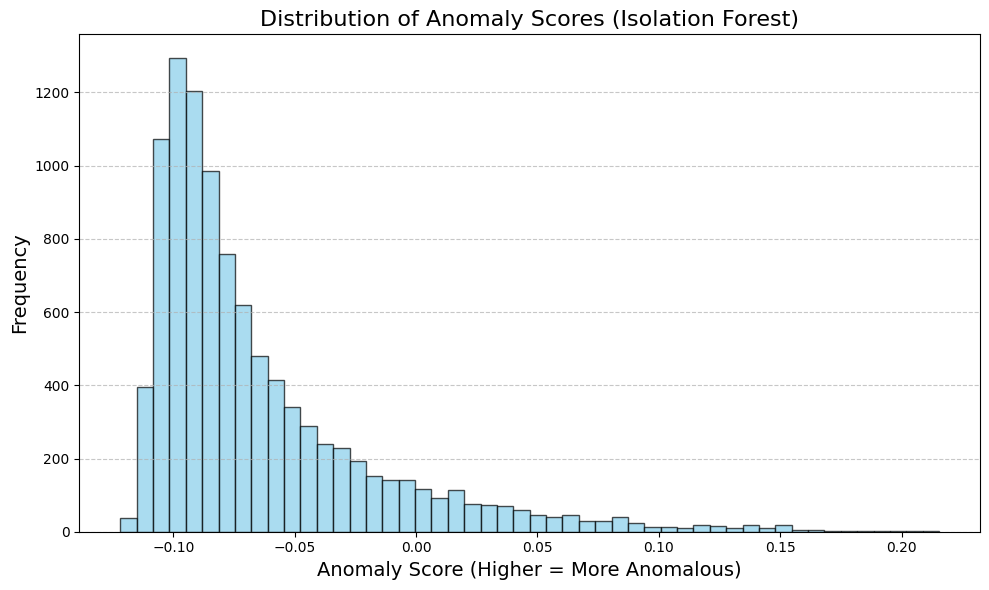

In [61]:
# Visualization 
print("\n--- Generating Visualizations ---")

# 1. Distribution of Anomaly Scores (Isolation Forest)
plt.figure(figsize=(10, 6))
plt.hist(results_df["anomaly_score_iforest"], bins=50, color="skyblue", alpha=0.7, edgecolor="black")
plt.title("Distribution of Anomaly Scores (Isolation Forest)", fontsize=16)
plt.xlabel("Anomaly Score (Higher = More Anomalous)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

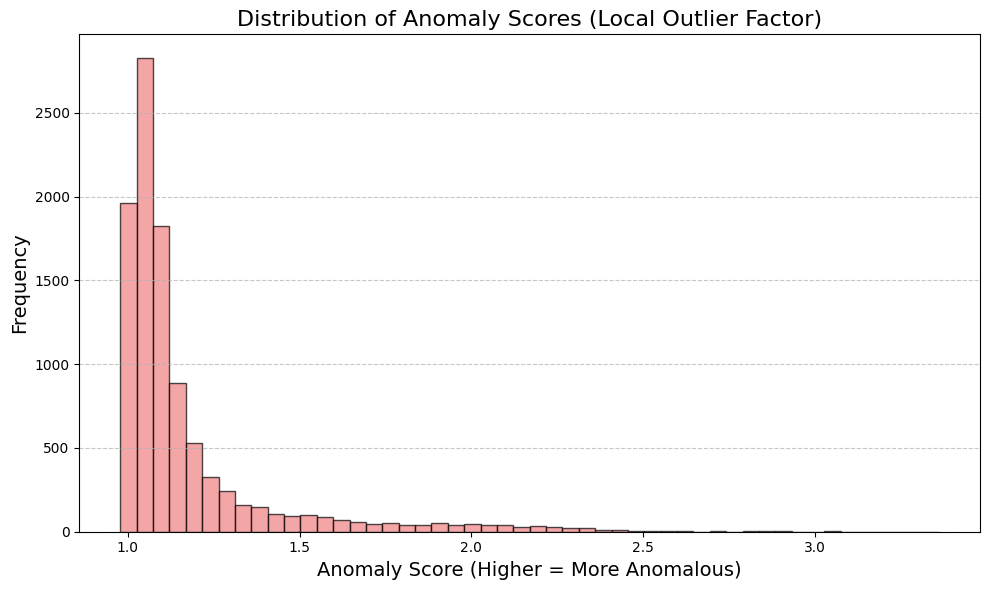

In [67]:
# Plot the distribution of LOF scores
plt.figure(figsize=(10, 6))
plt.hist(scores_lof, bins=50, color="lightcoral", alpha=0.7, edgecolor="black")
plt.title("Distribution of Anomaly Scores (Local Outlier Factor)", fontsize=16)
plt.xlabel("Anomaly Score (Higher = More Anomalous)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Running t-SNE (perplexity=30)...


/home/luuka/miniconda/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Plotting annotated t-SNE...


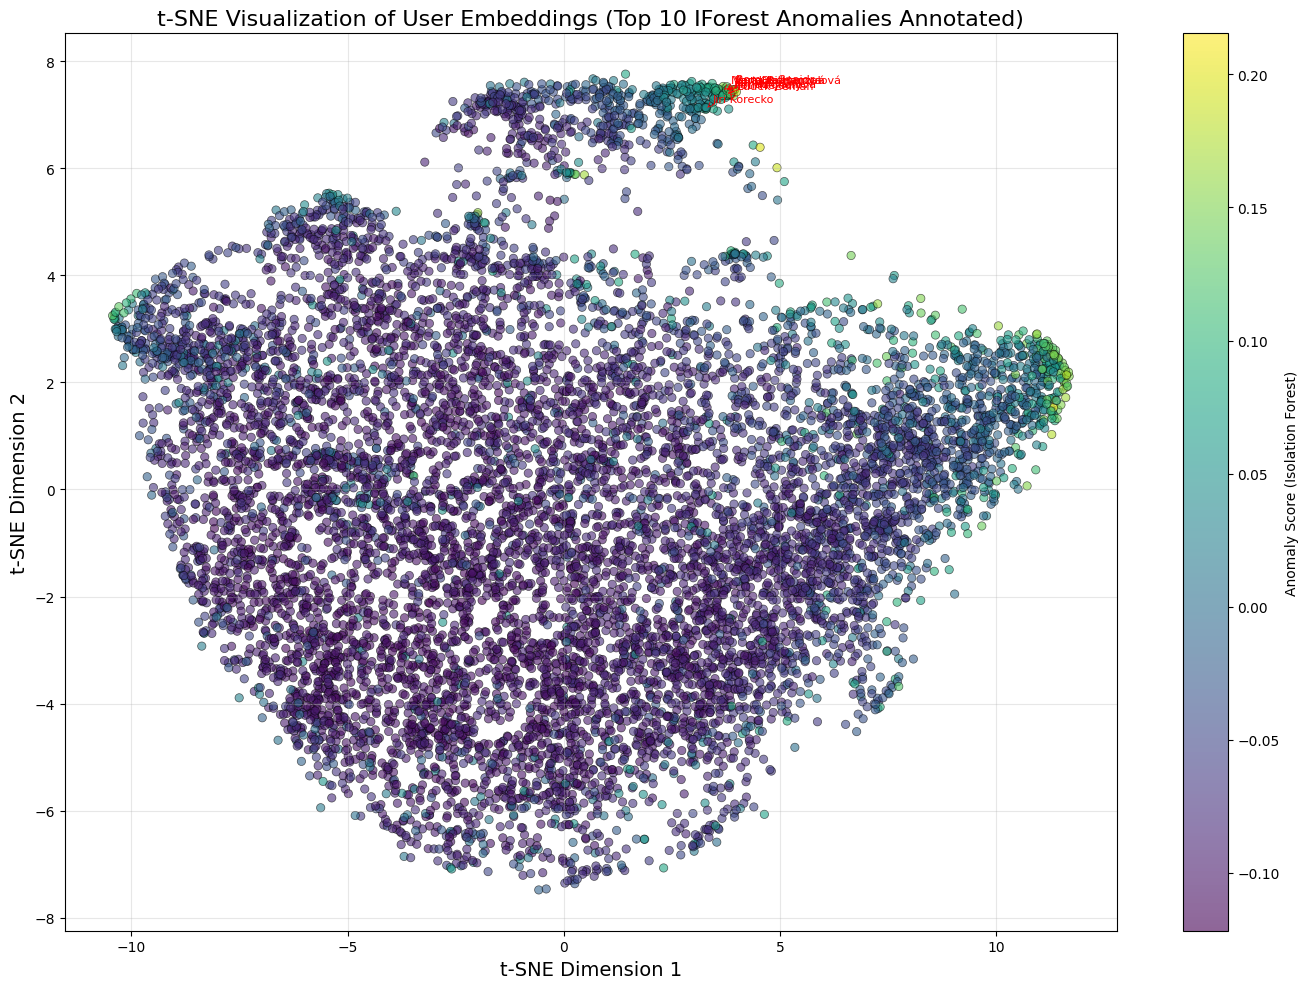

In [ ]:
# t-SNE Visualization with Annotations
# Ensure we have enough data points for t-SNE perplexity
perplexity_val = min(30, account_embeddings.shape[0] - 1)
if perplexity_val <= 0:
    print("Not enough samples for t-SNE visualization.")
else:
    print(f"Running t-SNE (perplexity={perplexity_val})...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val, max_iter=300, n_jobs=-1) # Reduced iterations, added n_jobs
    tsne_embs = tsne.fit_transform(account_embeddings)

    print("Plotting annotated t-SNE...")
    plt.figure(figsize=(14, 10)) # Larger plot for annotations

    # Determine coloring
    scatter_color_data = scores_iforest
    color_label = "Anomaly Score (Isolation Forest)"
    cmap = "viridis"

    scatter = plt.scatter(
        tsne_embs[:, 0],
        tsne_embs[:, 1],
        c=scatter_color_data,
        cmap=cmap,
        alpha=0.6,
        edgecolor='k',
        linewidth=0.5,
        norm=plt.Normalize(vmin=np.nanmin(scatter_color_data), vmax=np.nanmax(scatter_color_data)) if cmap != "coolwarm" else None # Normalize non-categorical
    )

    plt.colorbar(scatter, label=color_label)
    plt.title(f"t-SNE Visualization of User Embeddings (Top {ANNOTATE_TOP_N} IForest Anomalies Annotated)", fontsize=16)
    plt.xlabel("t-SNE Dimension 1", fontsize=14)
    plt.ylabel("t-SNE Dimension 2", fontsize=14)
    plt.grid(alpha=0.3)

    # Add Annotations for Top N authors (from the filtered results)
    top_authors_to_annotate = results_df_filtered.head(ANNOTATE_TOP_N)

    for _, row in top_authors_to_annotate.iterrows():
        # Find the original index of the author in the 'processed_authors' list
        try:
            original_index = processed_authors.index(row['author'])
            plt.annotate(
                #f"{row['author']} ({row['anomaly_score_iforest']:.2f})", # Annotate with author name + score
                 f"{row['author']}", # Annotate with author name only for less clutter
                (tsne_embs[original_index, 0], tsne_embs[original_index, 1]),
                textcoords="offset points",
                xytext=(5,5),
                ha='left',
                fontsize=8,
                color='red',
                arrowprops=dict(arrowstyle="->", color='red', lw=0.5, connectionstyle="arc3,rad=0.3") # Added connection style
            )
        except ValueError:
             print(f"Warning: Author '{row['author']}' not found in original processed list for annotation.")
        except IndexError:
             print(f"Warning: Index issue for author '{row['author']}' during annotation.")


    plt.tight_layout()
    plt.show()


Running t-SNE (perplexity=30)...
Plotting t-SNE with LOF scores...


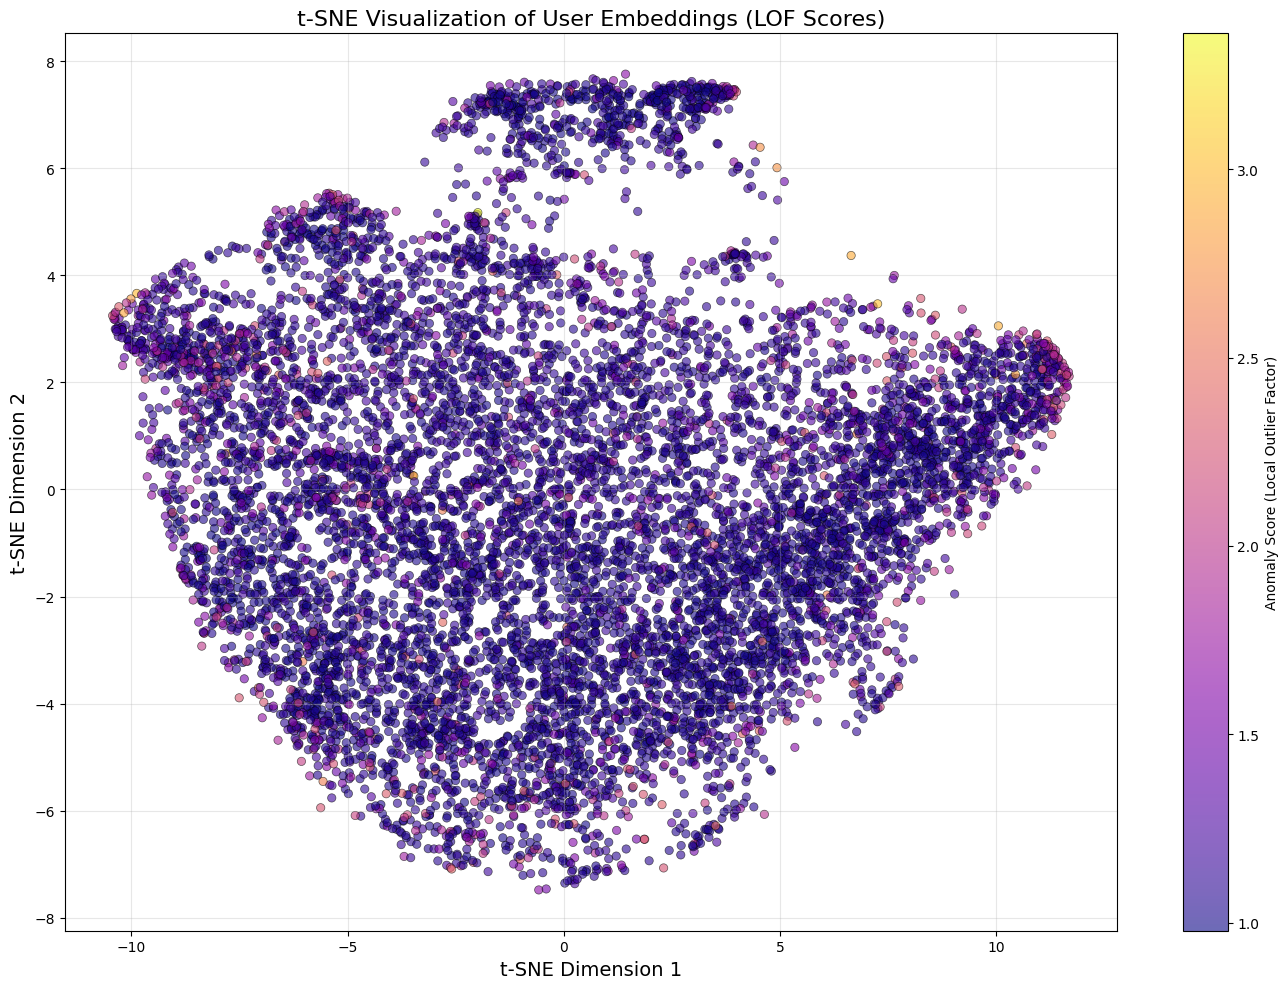

In [68]:
# t-SNE Visualization with LOF Scores
perplexity_val = min(30, account_embeddings.shape[0] - 1)
if perplexity_val <= 0:
    print("Not enough samples for t-SNE visualization.")
else:
    print(f"Running t-SNE (perplexity={perplexity_val})...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val, max_iter=300, n_jobs=-1)
    tsne_embs = tsne.fit_transform(account_embeddings)

    print("Plotting t-SNE with LOF scores...")
    plt.figure(figsize=(14, 10))

    scatter = plt.scatter(
        tsne_embs[:, 0],
        tsne_embs[:, 1],
        c=scores_lof,
        cmap="plasma",
        alpha=0.6,
        edgecolor='k',
        linewidth=0.5,
        norm=plt.Normalize(vmin=np.nanmin(scores_lof), vmax=np.nanmax(scores_lof))
    )

    plt.colorbar(scatter, label="Anomaly Score (Local Outlier Factor)")
    plt.title("t-SNE Visualization of User Embeddings (LOF Scores)", fontsize=16)
    plt.xlabel("t-SNE Dimension 1", fontsize=14)
    plt.ylabel("t-SNE Dimension 2", fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [66]:
# Show Sample Comments
# (Kept the logic from the previous script, using the filtered top/bottom from IForest)

print(f"\n--- Sample comments from Top {ANNOTATE_TOP_N} Anomalous Authors (iForest, >= {MIN_COMMENTS_FOR_REPORTING} comments) ---")
top_authors_list = results_df_filtered.head(ANNOTATE_TOP_N)["author"].tolist()
for author in top_authors_list:
    author_comments = czech_comments[czech_comments["author"] == author]["text"].tolist()[:5] # Show first 5
    print(f"\nAuthor: {author} (Score: {results_df[results_df['author'] == author]['anomaly_score_iforest'].iloc[0]:.2f})")
    for i, comment in enumerate(author_comments):
        print(f" - Comment {i+1}: {comment}")
    print("-" * 40)

print(f"\n--- Sample comments from Least {ANNOTATE_TOP_N} Anomalous Authors (iForest, >= {MIN_COMMENTS_FOR_REPORTING} comments) ---")
bottom_authors_list = results_df_filtered.tail(ANNOTATE_TOP_N)["author"].tolist()
for author in bottom_authors_list:
    author_comments = czech_comments[czech_comments["author"] == author]["text"].tolist()[:5] # Show first 5
    print(f"\nAuthor: {author} (Score: {results_df[results_df['author'] == author]['anomaly_score_iforest'].iloc[0]:.2f})")
    for i, comment in enumerate(author_comments):
        print(f" - Comment {i+1}: {comment}")
    print("-" * 40)



--- Sample comments from Top 10 Anomalous Authors (iForest, >= 5 comments) ---

Author: Petr Nejedly (Score: 0.13)
 - Comment 1: souhlas, dejte to tam... neprestanu, chlast je jedina radost v tomto state... kdo nechlasta, neni cech!jen abyste pak nemuseli dat nalepku skoro na vse, a bez ni by zustal jen tvaroh, brambor a zeli... ikdyz ja znam zemedelce, zrovna ty pole jsou vedle silnic a dalnic
 - Comment 2: vlny je technicky a dejove poutavy film urcitym presahem, nemam mu vytknout ale za srdicko mi nechytl.... nicmene kdyz vidim kolikrat je tam film substance, tak je mi teskno :(
 - Comment 3: a stejne to bude cele jinak...
 - Comment 4: ukrajina jako suverenni stat zrejme skoncila... trump vse bere jako obchod a diky svemu egu specha na ukonceni valky skoro za jakoukoli cenu... vysledek bude ten, ze si rusko usa ukrajinu nejak rozkouskuji a tuhle dohodu predlozi ukrajine... ta z principu odmitne, usa naoplatku ukonci veskerou podporu... opet ego, rusko do mesice udela z ukrajiny pe

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of anomaly scores
plt.figure(figsize=(10, 6))
plt.hist(results_df["anomaly_score"], bins=50, color="skyblue", alpha=0.7, edgecolor="black")
plt.title("Distribution of Anomaly Scores", fontsize=16)
plt.xlabel("Anomaly Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
# Show Sample Comments from Top Anomalous Authors
top_authors = results_df.head(10)["author"].tolist()

print("\nSample comments from top anomalous authors:\n")
for author in top_authors:
    author_comments = czech_comments[czech_comments["author"] == author]["text"].tolist()[:5]
    print(f"Author: {author}")
    for comment in author_comments:
        print(f" - {comment}")
    print("-" * 40)

In [ ]:
# Show Sample Comments from Least Anomalous Authors 
least_anomalous_authors = results_df.tail(10)["author"].tolist()

print("\nSample comments from least anomalous authors:\n")
for author in least_anomalous_authors:
    author_comments = czech_comments[czech_comments["author"] == author]["text"].tolist()[:5]
    print(f"Author: {author}")
    for comment in author_comments:
        print(f" - {comment}")
    print("-" * 40)